# THE CNN CLASSIFIER
* Exploratory data analysis and visualizations of dataset
* Model training (data augmentation as well)
* Model evaluation and visualization

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import pickle


## Load labels of dataset

In [3]:
hasy_data_labels = pd.read_csv("hasy-data-labels.csv")
hasy_data_labels["latex"].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '\\rightarrow', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '\\pi', '\\alpha', '\\beta', '\\sum', '\\sigma', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 'u', 'v', 'w', 'x', 'y', 'z', '\\Sigma', '\\gamma',
       '\\Gamma', '\\delta', '\\Delta', '\\zeta', '\\eta', '\\theta',
       '\\Theta', '\\epsilon', '\\varepsilon', '\\iota', '\\kappa',
       '\\varkappa', '\\lambda', '\\Lambda', '\\mu', '\\nu', '\\xi',
       '\\Xi', '\\Pi', '\\rho', '\\varrho', '\\tau', '\\phi', '\\Phi',
       '\\varphi', '\\chi', '\\psi', '\\Psi', '\\omega', '\\Omega',
       '\\partial', '\\int', '\\cdot', '\\leq', '\\geq', '<', '>',
       '\\subset', '\\supset', '\\subseteq', '\\supseteq', '\\cong',
       '\\propto', '-', '+', '\\mathbb{R}', '\\$', '\\{', '\\copyright',
       '\\d

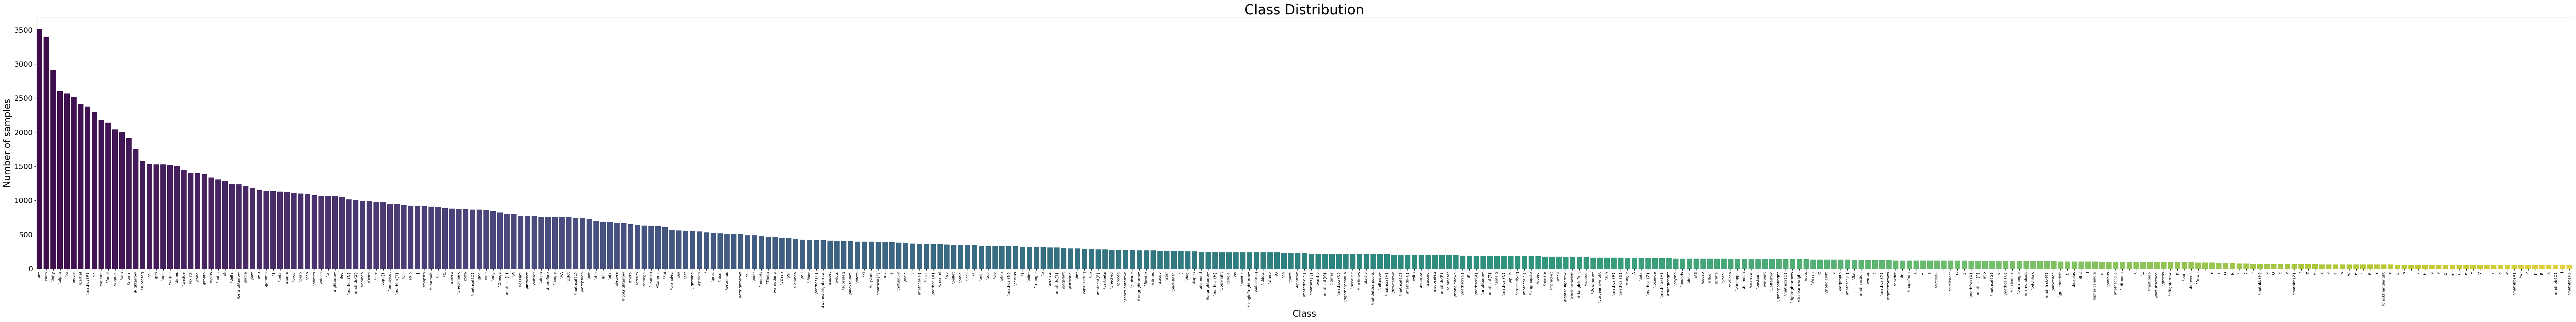

In [4]:
# visualize class distribution
class_distribution = hasy_data_labels['latex'].value_counts()

plt.figure(figsize=(100,10))  # Adjust figure size
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution', fontsize=30)  # Adjust font size
plt.xlabel('Class', fontsize=20)  # Adjust font size
plt.ylabel('Number of samples', fontsize=20)  # Adjust font size
plt.xticks(rotation=90, fontsize=8)  # Adjust font size
plt.yticks(fontsize=16)  # Adjust font size
plt.show()

# NOTE MAKE SURE TO DOUBLE CLICK SO YOU CAN ZOOM IN!

## Load subset of actual dataset
* This is because we don't want to train model on all symbols

In [5]:
def get_image(df, index):
    image = Image.open(df['path'][index])
    image = ImageOps.grayscale(image)
    image = np.array(image)
    image = image/255.0
    return image

def get_label(df, index):
    return df['latex'][index]

In [6]:
# These are the symbols we wish to import
wantedSymbols = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "+", "-", "/", "(", ")", "\sqrt{}", "\\ast"]
hasySubset = hasy_data_labels.loc[hasy_data_labels["latex"].isin(wantedSymbols)]
hasySubset["latex"].unique()
hasySubset = hasySubset.reset_index(drop=True)

In [7]:
hasySubset.head(3)

,path,symbol_id,latex,user_id
0,hasy-data/v2-00345.png,70,0,10
1,hasy-data/v2-00346.png,70,0,31
2,hasy-data/v2-00347.png,70,0,10


In [8]:
# Begin loading images/labels and storing them...
images = []
labels = []
for i in range(len(hasySubset)):
    images.append(get_image(hasySubset, i))
    labels.append(get_label(hasySubset, i))

# load in additional "(" and ")" that we manually created since the dataset did not contain these symbols
currLabel = "("
for index in range(168233, 168371, 1):
    if(index == 168302):
        currLabel = ")"
    image = Image.open("hasy2extended/images/v2-" + str(index) + ".png")
    image = ImageOps.grayscale(image)
    image = np.array(image)
    image = image/255.0
    
    images.append(image)
    labels.append(currLabel)

np.unique(np.array(labels))

array(['(', ')', '+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '\\ast', '\\sqrt{}'], dtype='<U7')

## Perform EDA of dataset
* We want to better understand the structure of the dataset especially the images, how they look, their colors, their intensities, etc.

In [9]:
# convert labels and images to numpy array for easier manipulation
labels = np.array(labels)
images = np.array(images)

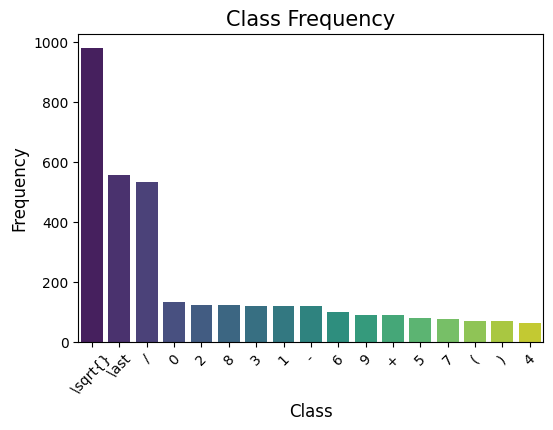

In [10]:
# create a DataFrame from labels to plot using seaborn, lets visualize :D
df_labels = pd.DataFrame(labels, columns=['Class'])

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df_labels, palette='viridis', order=df_labels['Class'].value_counts().index)
plt.title('Class Frequency', fontsize=15)
plt.xticks(rotation=45)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig("figures/hasySubset_distribution", dpi=500)
plt.show()


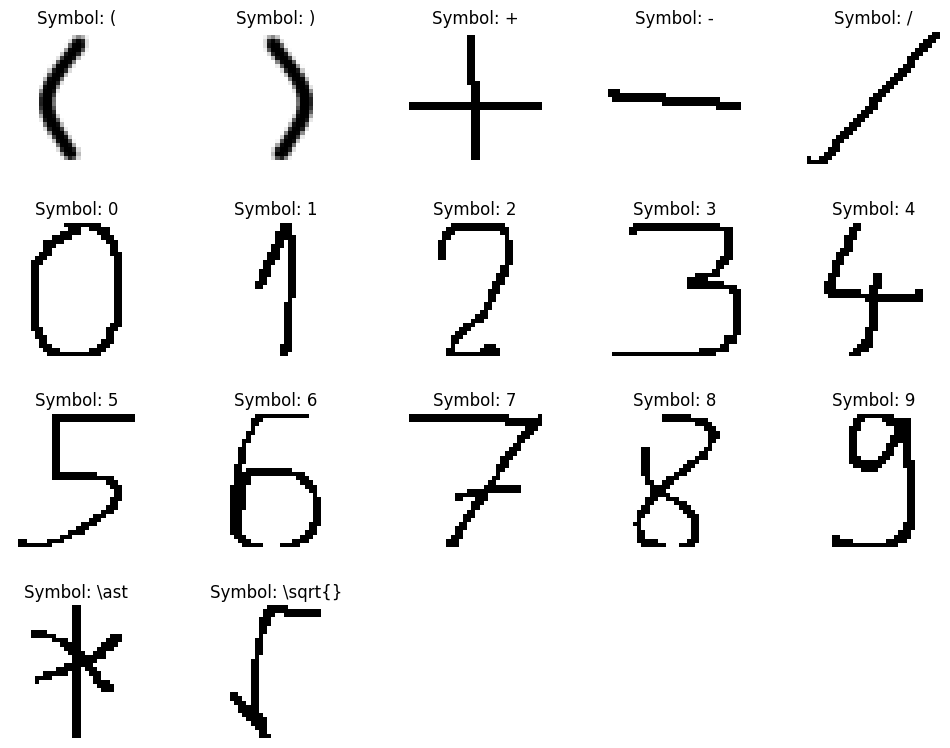

In [11]:
# determine grid dimensions
unique = np.unique(labels)
grid_size = int(np.ceil(np.sqrt(len(unique))))

# 2. sample Images from Each Class
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12,12))  # Adjust dynamically
axes = axes.ravel()
for i in np.arange(0, len(unique)):
    # Find the first instance of a class in the dataset and display the image
    ax = axes[i]
    ax.imshow(images[np.argmax(labels==unique[i])], cmap='gray')
    ax.set_title(f"Symbol: {unique[i]}", fontsize=12)
    ax.axis('off')

# Hide remaining axes
for i in range(len(unique), len(axes)):
    fig.delaxes(axes[i]) 

plt.subplots_adjust(wspace=0.5)
plt.show()

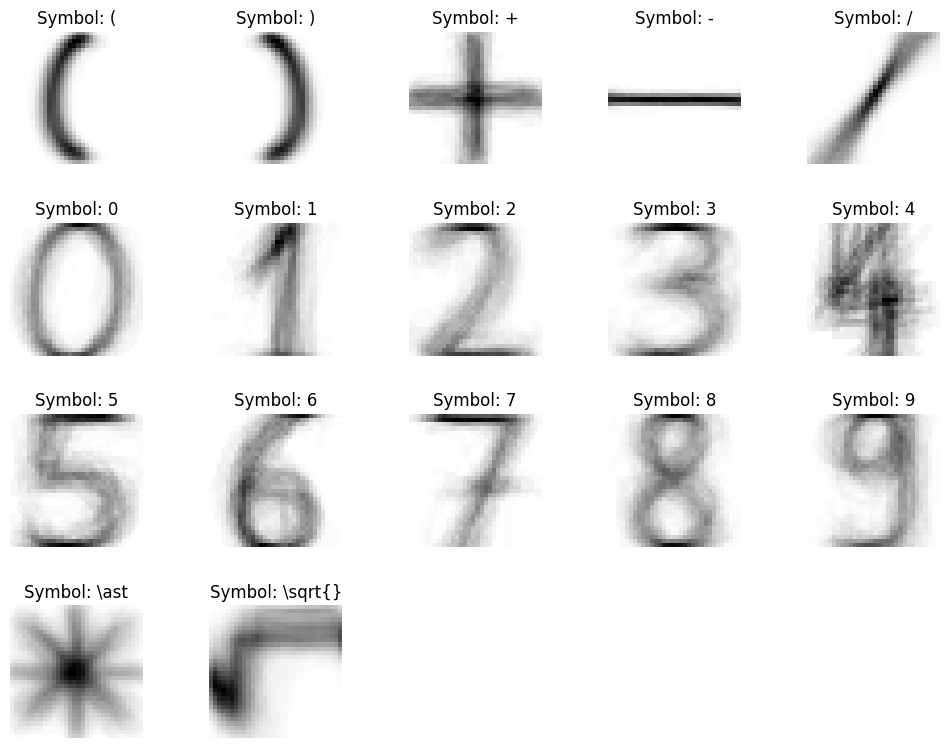

In [12]:
# lets also see the average of each image. 

fig, axes = plt.subplots(grid_size, grid_size, figsize=(12,12))  # Adjust dynamically
axes = axes.ravel()

for i, label in enumerate(unique):
    # Find all images of a class, calculate the mean across them
    avg_image = images[labels==label].mean(axis=0)
    
    ax = axes[i]
    ax.imshow(avg_image, cmap='gray')
    ax.set_title(f"Symbol: {label}", fontsize=12)
    ax.axis('off')

# Hide remaining axes
for i in range(len(unique), len(axes)):
    fig.delaxes(axes[i]) 

plt.subplots_adjust(wspace=0.5)
plt.show()

Observations:
* Notice how symbols like 1 in the dataset seem to have that edge on the top a lot
* Notice that 4 is very blurry because there are two different ways people write 4
* Notice that the 9 looks like a 'g'
* Notice that the '(' and ')' we manually created lacks diversity in the samples, i.e. they are all very similar
* Notice that the '-' sign is very straight on average, so any rotations may cause issues in predictions.
* Notice that '3' and '8' are structurally quite similar. It looks like 3 is the half of 8. 
* We may run into classification errors for 2 and 7 since they are also structurally similar

In [13]:
# 3. size of the images (should be 32x32 according to dataset)

shapes = np.array([img.shape for img in images])
unique_shapes, counts_shapes = np.unique(shapes, return_counts=True, axis=0)
print("unieq image sizes and their counts:")
for us, cs in zip(unique_shapes, counts_shapes):
    print(f"Shape: {us}, Count: {cs}")

unieq image sizes and their counts:
Shape: [32 32], Count: 3433


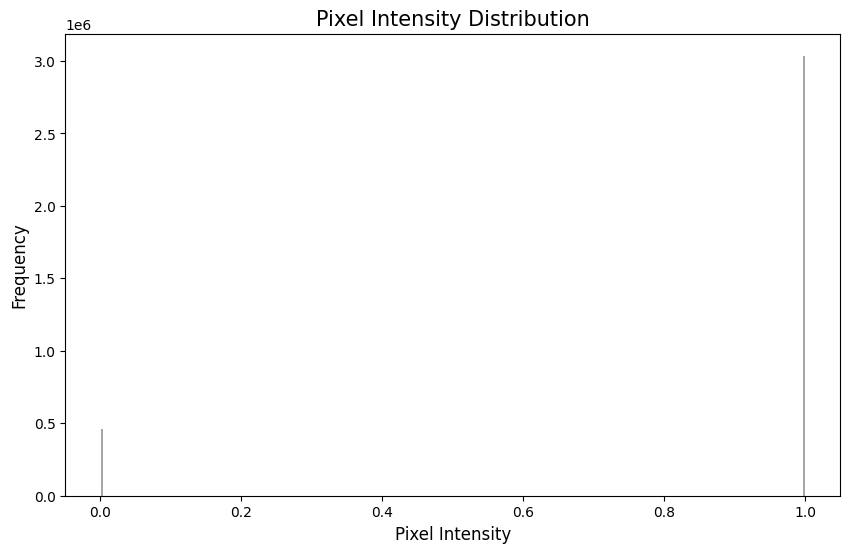

In [14]:
# 4. lets see pixel Intensity Distribution -- could help improve our image processing
plt.figure(figsize=(10,6))
plt.hist(images.ravel(), bins=256, color='gray', alpha=0.7, rwidth=0.9)
plt.title('Pixel Intensity Distribution', fontsize=15)
plt.xlabel('Pixel Intensity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(False)
plt.show()

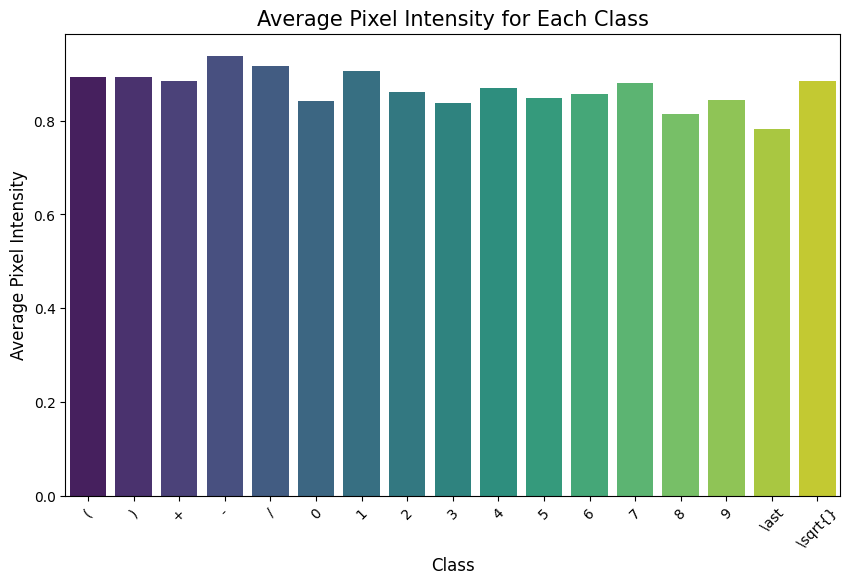

In [15]:
# 5. average Pixel Intensity for Each Class
avg_intensity = [images[labels == label].mean() for label in unique]
plt.figure(figsize=(10,6))
sns.barplot(x=unique, y=avg_intensity, palette='viridis')
plt.title('Average Pixel Intensity for Each Class', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Average Pixel Intensity', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## CNN Model Training

In [16]:
# Basic image pre-processing

image_height = 32
image_width = 32

rawImages = images.copy()
images = np.array(images).reshape(-1, image_height, image_width, 1)

In [17]:
# set up encoding because we have discrete classes
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

labels_categorical = to_categorical(labels_encoded)
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

Data augmentation technique (create samples by randomly zooming out a bit) since we lack samples and this can add good variability

In [18]:
def random_zoom_out(image):
    zoom_factor = np.random.uniform(1, 1.1)
    height, width = image.shape[0], image.shape[1]
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    resized_image = cv2.resize(image, (new_width, new_height))
    top = (new_height - height) // 2
    left = (new_width - width) // 2
    padded_image = cv2.copyMakeBorder(resized_image, top, top, left, left, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    result = padded_image[:height, :width]
    return np.expand_dims(result, axis=-1)  # add the third dimension

We create our CNN architecture

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(wantedSymbols), activation='softmax', kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                    

In [21]:
# data generator with random rotations and shifts as well, use our random zoom out function
datagen = ImageDataGenerator(
    rotation_range=10,
    preprocessing_function=random_zoom_out,
    width_shift_range=0.1,
    height_shift_range=0.01,
    horizontal_flip=False,
    vertical_flip=False)

# define a early stopping to avoid overfitting!
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

TRAIN

In [22]:
# use datagen.flow instead of train_generator and valid_generator
# train!
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
85/85 [==============================] - 9s 87ms/step - loss: 3.8780 - accuracy: 0.4823 - val_loss: 1.9248 - val_accuracy: 0.7671
Epoch 2/50
85/85 [==============================] - 7s 87ms/step - loss: 1.6577 - accuracy: 0.7583 - val_loss: 1.3170 - val_accuracy: 0.8370
Epoch 3/50
85/85 [==============================] - 8s 89ms/step - loss: 1.3383 - accuracy: 0.7973 - val_loss: 1.0433 - val_accuracy: 0.8690
Epoch 4/50
85/85 [==============================] - 8s 91ms/step - loss: 1.0791 - accuracy: 0.8408 - val_loss: 0.8687 - val_accuracy: 0.9083
Epoch 5/50
85/85 [==============================] - 7s 85ms/step - loss: 0.8900 - accuracy: 0.8732 - val_loss: 0.6923 - val_accuracy: 0.9316
Epoch 6/50
85/85 [==============================] - 8s 88ms/step - loss: 0.8262 - accuracy: 0.8839 - val_loss: 0.7090 - val_accuracy: 0.9214
Epoch 7/50
85/85 [==============================] - 8s 89ms/step - loss: 0.7324 - accuracy: 0.9035 - val_loss: 0.6353 - val_accuracy: 0.9243
Epoch 8/50
85

In [23]:
# Assuming 'model' is your Keras model object
import graphviz
import pydot

## Save Model

In [24]:
def saveModel():
    model.save('cnn.h5')  # creates a HDF5 file 'my_model.h5'

    # Saving the label encoder
    with open('label_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(le, le_dump_file)

# we dont save for the demo
# saveModel()

## CNN Model Evaluation

In [25]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Final accuracy on test set: ", scores[1])

Final accuracy on test set:  0.9650654792785645


In [26]:
# predicting the classes using model.predict and taking the class with highest probability
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# convert encoded labels back to original form
y_pred_labels = le.inverse_transform(y_pred_classes)
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))  # assuming y_test is still in one-hot encoded form

22/22 [==============================] - 0s 13ms/step


In [27]:
# simple eclassification report
print('Classification Report for Test Set')
print(classification_report(y_true_labels, y_pred_labels))


Classification Report for Test Set
              precision    recall  f1-score   support

           (       0.94      1.00      0.97        15
           )       1.00      1.00      1.00        16
           +       0.77      1.00      0.87        17
           -       1.00      1.00      1.00        15
           /       0.97      0.97      0.97       110
           0       1.00      0.96      0.98        27
           1       0.95      0.84      0.89        25
           2       0.90      0.96      0.93        28
           3       1.00      0.95      0.98        22
           4       0.87      0.76      0.81        17
           5       0.89      1.00      0.94        17
           6       0.90      1.00      0.95        18
           7       1.00      0.89      0.94        19
           8       1.00      0.90      0.95        20
           9       0.85      0.79      0.81        14
        \ast       1.00      0.98      0.99       120
     \sqrt{}       0.98      0.99      0.99   

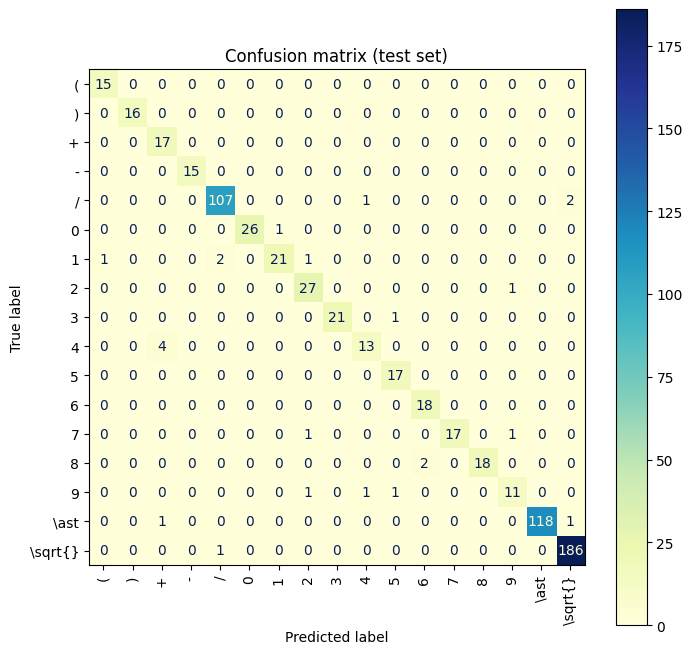

In [28]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot(cmap='YlGnBu', xticks_rotation='vertical', ax=ax)
plt.title("Confusion matrix (test set)")
plt.show()

C:\Users\tsept\AppData\Local\Temp\ipykernel_22428\314047465.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


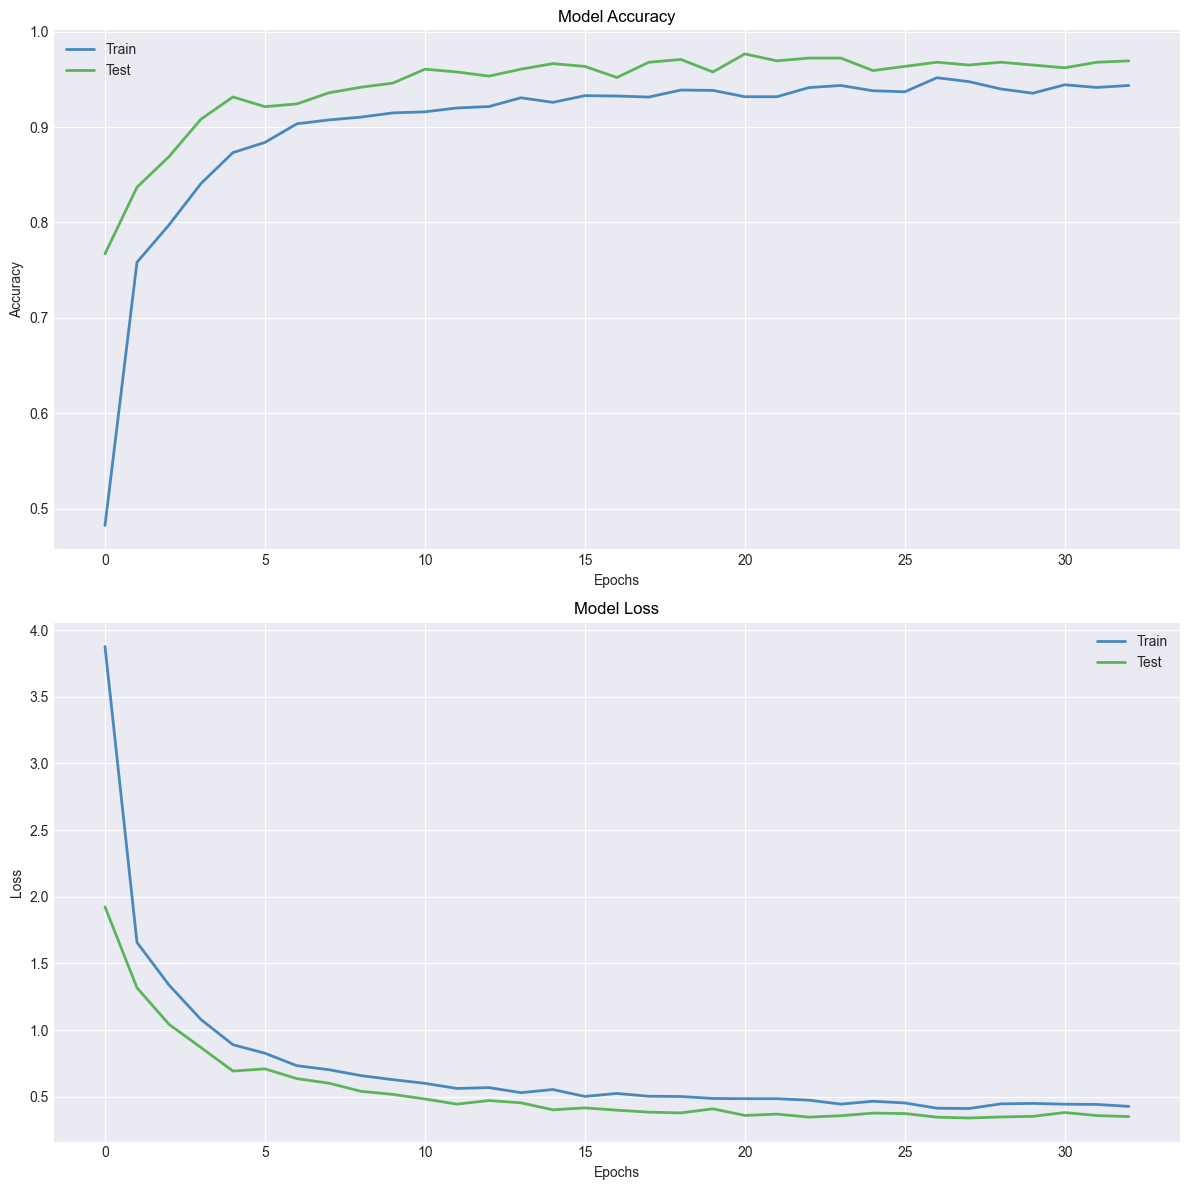

In [29]:
# use seaborn's style (looks nicer )
plt.style.use('seaborn-darkgrid')

# create a color palette 
palette = plt.get_cmap('Set1')

# create subplots
fig, axes = plt.subplots(2, 1, figsize=(12,12))

# plot accuracy
axes[0].plot(history.history['accuracy'], marker='', color=palette(1), linewidth=2, alpha=0.9, label='Train')
axes[0].plot(history.history['val_accuracy'], marker='', color=palette(2), linewidth=2, alpha=0.9, label='Test')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight=0, color='black')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# plot loss
axes[1].plot(history.history['loss'], marker='', color=palette(1), linewidth=2, alpha=0.9, label='Train')
axes[1].plot(history.history['val_loss'], marker='', color=palette(2), linewidth=2, alpha=0.9, label='Test')
axes[1].set_title('Model Loss', fontsize=12, fontweight=0, color='black')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# show the plot
plt.tight_layout()
plt.show()
